# Import libraries

In [1]:
import json
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt

# Example of data format for a single scan's MRIQC output

In [2]:
filepath = "./mriqc_output/sub-2332918_ses-NAPFU48_run-001_T1w.json"

with open(filepath, "r+") as file:
    data = json.load(file)
    del data['bids_meta']
    del data['provenance']
    pprint.pprint(data)

{'cjv': 0.4483252215563519,
 'cnr': 3.03588107158742,
 'efc': 0.5736794793449945,
 'fber': 3486.3879754136465,
 'fwhm_avg': 3.680683333333333,
 'fwhm_x': 3.75564,
 'fwhm_y': 3.75121,
 'fwhm_z': 3.5352,
 'icvs_csf': 0.23896913950456913,
 'icvs_gm': 0.41155280110393555,
 'icvs_wm': 0.34947805939149534,
 'inu_med': 0.7374693751335144,
 'inu_range': 0.2513059496879577,
 'qi_1': 5.195251898058409e-05,
 'qi_2': 0.004795732602123701,
 'rpve_csf': 26.88707975840483,
 'rpve_gm': 15.121849315940365,
 'rpve_wm': 20.11346722779336,
 'size_x': 176,
 'size_y': 240,
 'size_z': 256,
 'snr_csf': 1.833606415582332,
 'snr_gm': 8.892356395367713,
 'snr_total': 8.892254479555502,
 'snr_wm': 15.95080062771646,
 'snrd_csf': 6.761179797230499,
 'snrd_gm': 21.856357429069693,
 'snrd_total': 20.089224774479476,
 'snrd_wm': 31.65013709713823,
 'spacing_x': 1.0,
 'spacing_y': 1.0,
 'spacing_z': 1.0,
 'summary_bg_k': 2392.801813776368,
 'summary_bg_mad': 0.0,
 'summary_bg_mean': 11.696939497924124,
 'summary_bg_me

# Function to find discrepancies in NeuroCI's output file

In [5]:
NeuroCI_results_file = "volumes.json"

#Find a discrepancy between FSL and FreeSurfer hippocampal volumes for a given scan
def find_discrepancy(json_results, filename):
    with open(json_results, "r+") as file:
        data = json.load(file)
        output = {}

        FSL = float(data[filename]['FSL'])
        FreeSurfer = float(data[filename]['FreeSurfer'])
        ASHS = float(data[filename]['ASHS'])

        output['FSL-FreeSurfer'] = abs(FSL-FreeSurfer)
        output['FSL-ASHS'] = abs(FSL-ASHS)
        output['ASHS-FreeSurfer'] = abs(ASHS-FreeSurfer)
        output['avg'] = (output['FSL-FreeSurfer'] + output['FSL-ASHS'] + output['ASHS-FreeSurfer']) / 3

        return output

#Example using the fn
find_discrepancy(NeuroCI_results_file, "sub-6852929_ses-NAPFU12_run-001_T1w.nii.gz")

{'FSL-FreeSurfer': 4142.1,
 'FSL-ASHS': 3241.5,
 'ASHS-FreeSurfer': 900.6000000000004,
 'avg': 2761.4}

# Making a list of all such dictionaries available in the 'mriqc_output' directory

In [6]:
mriqc_output_directory = "./mriqc_output"
NeuroCI_results_file = "volumes.json"
list_of_mriqc = []

for filename in os.listdir(mriqc_output_directory):
    file_path = os.path.join(mriqc_output_directory, filename)
    with open(file_path, "r+") as file:
        data = json.load(file)
        del data['bids_meta']
        del data['provenance']
        data['filename'] = filename[:-5] + ".nii.gz" #Note that I added this so we know which result is of which scan.
        data['discrepancy'] = find_discrepancy(NeuroCI_results_file, data['filename']) #This is also added by me!
        list_of_mriqc.append(data)
        
pprint.pprint(list_of_mriqc[2]) #each element of the list is the dictionary of a single MRIQC result file.

{'cjv': 0.4402655518102789,
 'cnr': 3.0837125671937127,
 'discrepancy': {'ASHS-FreeSurfer': 555.4499999999998,
                 'FSL-ASHS': 455.75,
                 'FSL-FreeSurfer': 99.69999999999982,
                 'avg': 370.2999999999999},
 'efc': 0.515784253186817,
 'fber': 1777.2382274965282,
 'filename': 'sub-5184448_ses-NAPFU24_run-001_T1w.nii.gz',
 'fwhm_avg': 3.854956666666667,
 'fwhm_x': 3.95674,
 'fwhm_y': 3.92712,
 'fwhm_z': 3.68101,
 'icvs_csf': 0.25097178024141803,
 'icvs_gm': 0.3895129482373964,
 'icvs_wm': 0.35951527152118556,
 'inu_med': 0.6520167589187622,
 'inu_range': 0.24013301730155945,
 'qi_1': 0.0,
 'qi_2': 0.004960950548379736,
 'rpve_csf': 22.706863870063838,
 'rpve_gm': 14.011962984147308,
 'rpve_wm': 17.763054505546087,
 'size_x': 176,
 'size_y': 240,
 'size_z': 256,
 'snr_csf': 1.7605463732839652,
 'snr_gm': 8.562109114721045,
 'snr_total': 9.372181985400816,
 'snr_wm': 17.793890468197443,
 'snrd_csf': 11.410702379463677,
 'snrd_gm': 45.18941936683528,
 

# List of all MRIQC features names

In [7]:
keys_not_to_include = ['discrepancy', 'filename']

features_list = [key for key in list_of_mriqc[0] if (not key in keys_not_to_include)]

# creating observations and target arrays

In [30]:
observations = list()
for data in list_of_mriqc:
    x = list()
    for feature in features_list:
        x.append(data[feature])
    observations.append(np.array(x))
observations = np.array(observations)

target = {}
for discrepancy_key in data['discrepancy']:
    y = list()
    for data in list_of_mriqc:
        y.append(data['discrepancy'][discrepancy_key])
    target[discrepancy_key] = np.array(y)

removing bad features

In [31]:
# finding bad features
for i, feature in enumerate(features_list):
    if np.nan_to_num(np.std(observations[:,i]))==0:
        keys_not_to_include.append(feature)

    if np.sum(observations[:,i])==0:
        keys_not_to_include.append(feature)

# removing bad features from observations matrix
new_observations = list()
for i, feature in enumerate(features_list):
    if not feature in keys_not_to_include:
        new_observations.append(observations[:, i])
new_observations = np.array(new_observations).T
observations = new_observations

# removing bad features from features_list
for key in keys_not_to_include:
    if key in features_list:
        features_list.remove(key)


normalizing features and target

In [32]:
for i, feature in enumerate(features_list):
    observations[:, i] = observations[:, i] - np.mean(observations[:, i])
    observations[:, i] = np.divide(observations[:, i], np.std(observations[:, i]))

for discrepancy_key in target:
    target[discrepancy_key] = target[discrepancy_key] - np.mean(target[discrepancy_key])
    target[discrepancy_key] = np.divide(target[discrepancy_key], np.std(target[discrepancy_key]))

# finding top positively correlated features

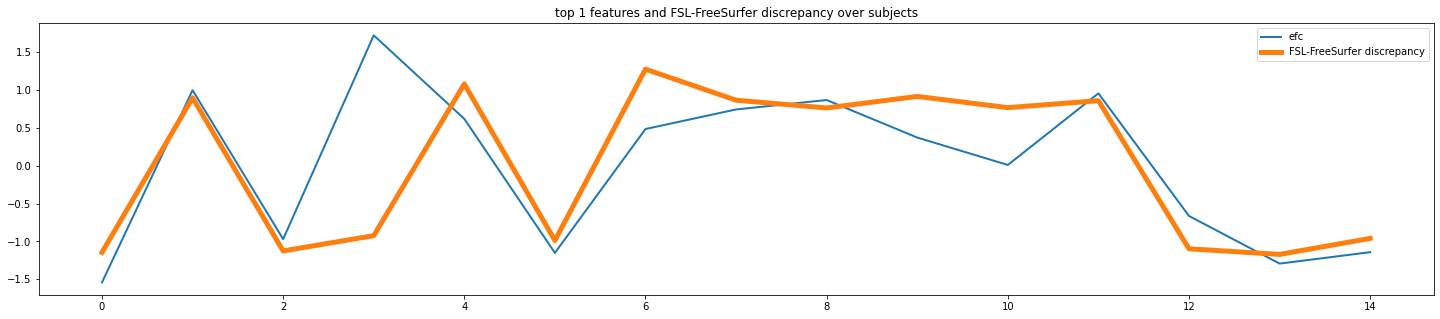

*** correlation of features with FSL-FreeSurfer discrepancy 
     correlation with feature -efc- = 0.69


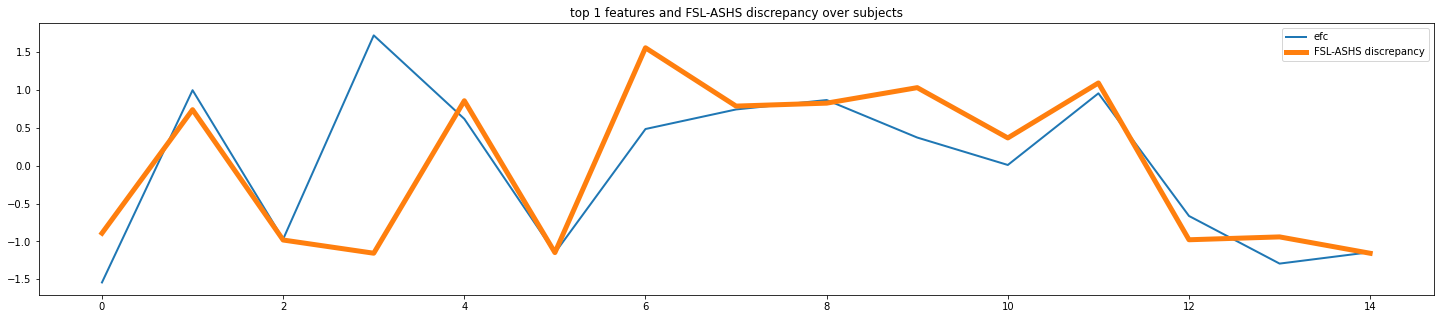

*** correlation of features with FSL-ASHS discrepancy 
     correlation with feature -efc- = 0.64


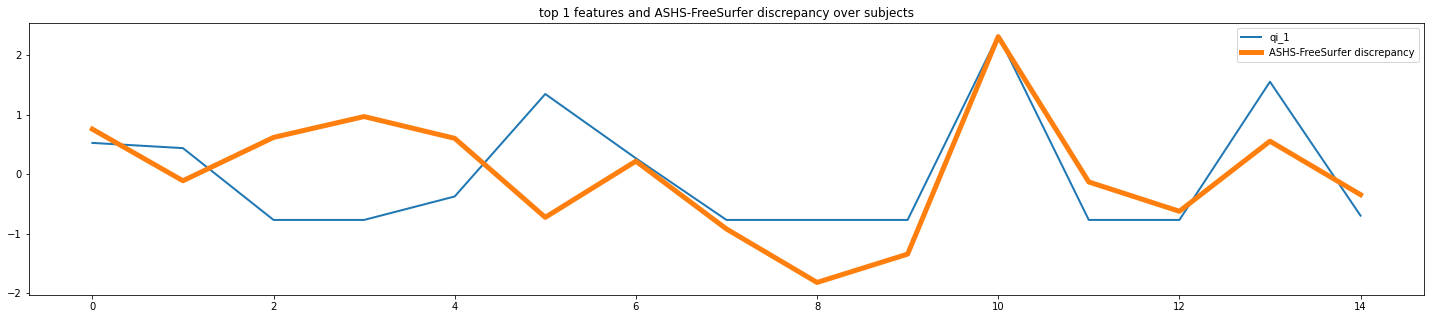

*** correlation of features with ASHS-FreeSurfer discrepancy 
     correlation with feature -qi_1- = 0.55


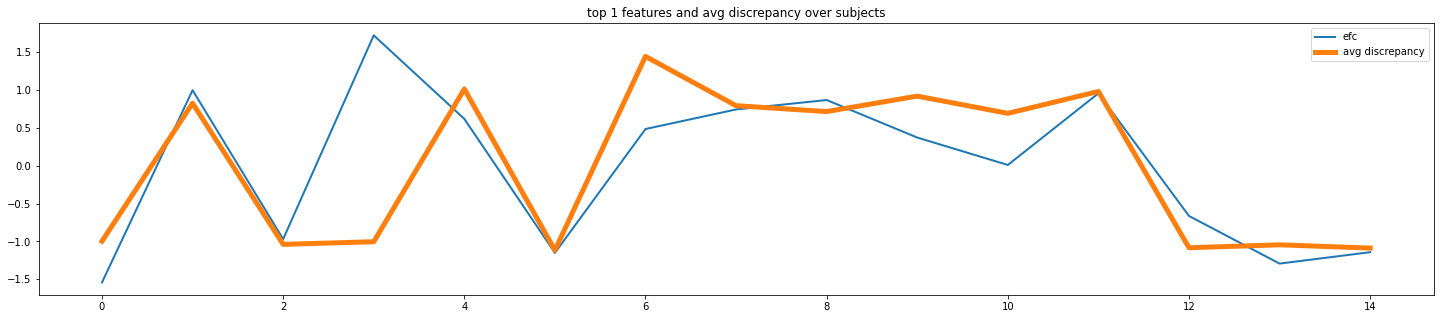

*** correlation of features with avg discrepancy 
     correlation with feature -efc- = 0.67


In [43]:
N = 1 # number of top features to find

for discrepancy_key in target:
    corr_list = list()
    for i, feature in enumerate(features_list):
        corr_list.append(np.corrcoef(target[discrepancy_key], observations[:, i])[0,1])
    corr_list = np.array(corr_list)
    # max_i = np.argmax(np.abs(corr_list))
    I = np.argsort(corr_list)
    I = I[-N:]
    top_features = [features_list[i] for i in I]
    top_corrs = [corr_list[i] for i in I]

    # plot values over subjects
    plt.figure(figsize=(25, 5))
    for i in I:
        plt.plot(observations[:, i], label=features_list[i], linewidth=2)
    plt.plot(target[discrepancy_key], label=discrepancy_key+' discrepancy', linewidth=5)
    plt.legend()
    plt.title('top ' + str(N) + ' features and ' + discrepancy_key + ' discrepancy over subjects')
    plt.show()

    # print correlation values of top correlated features
    print('*** correlation of features with '+ discrepancy_key +' discrepancy ')
    for i in range(N):
        print('     correlation with feature -' + top_features[i] + '- = %.2f' %top_corrs[i])